In [155]:
from PIL import Image
import numpy as np
from collections import Counter

In [156]:
ORIG_BACKGROUND = 128
ORIG_WHITE = 255
ORIG_BLACK = 0
ORIG_ZERO = 179

In [157]:
NEW_BACKGROUND = 0
NEW_WHITE = 255
NEW_BLACK = 128
NEW_ZERO = 0  # Don't need zero, need only background

In [158]:
change = {
    ORIG_BACKGROUND: NEW_BACKGROUND,
    ORIG_WHITE: NEW_WHITE,
    ORIG_BLACK: NEW_BLACK,
    ORIG_ZERO: NEW_ZERO
}

In [159]:
def change_colors_t(x):
    return change[x]

change_colors = np.vectorize(change_colors_t)

In [205]:
blocks_names = list("ABCDEFGHIJKL")
all_blocks = {
    name: change_colors(np.array(Image.open(f"./blocks/{name}.png"))) for name in blocks_names
}

In [206]:
standard_blocks_names = list("DEFGHIJKL")
standard_blocks = {
    name: change_colors(np.array(Image.open(f"./blocks/{name}.png"))) for name in standard_blocks_names
}

In [172]:
C_block_raw = np.array(Image.open(f"./blocks/C.png"))
zero = None

In [180]:
y, x = np.meshgrid(np.arange(C_block_raw.shape[1]), np.arange(C_block_raw.shape[0]))

In [188]:
zero_locs = set([y for y, x in np.transpose(np.nonzero(np.vectorize(lambda x, y: C_block_raw[x, y] == ORIG_ZERO)(x, y)))])
assert(len(zero_locs) == 1)
zero_loc = list(zero_locs)[0] % 30

In [196]:
c_right_phase, _ = get_right_phase(change_colors(C_block_raw))
zero_loc, c_right_phase
zero_phase = zero_loc - c_right_phase
zero_phase

18

In [161]:
def is_tip(img, x, y):
    ydim, xdim = img.shape
    return y != 0 and y != ydim - 1 and \
           img[y, x] != NEW_BACKGROUND and \
           img[y - 1, x] == NEW_BACKGROUND and \
           img[y + 1, x] == NEW_BACKGROUND

def is_left_tip(img, x, y):
    return is_tip(img, x, y) and x != 0 and img[y, x - 1] == NEW_BACKGROUND

def is_right_tip(img, x, y):
    ydim, xdim = img.shape
    return is_tip(img, x, y) and x != xdim - 1 and img[y, x + 1] == NEW_BACKGROUND

In [162]:
from functools import partial

In [198]:
CONST_LEFT_PHASE = 7

def get_left_phase(block):
    ydim, xdim = block.shape
    xmesh, ymesh = np.meshgrid(np.arange(xdim), np.arange(ydim))
    left_tips = np.transpose(np.nonzero(np.vectorize(partial(is_left_tip, block))(xmesh, ymesh)))
    left_phase = set([(x % 8, y % 30) for y, x in left_tips])
    assert(len(left_phase) == 1)
    left = list(left_phase)[0][1]
    assert(left == CONST_LEFT_PHASE)
    return left, left_tips

def get_right_phase(block):
    ydim, xdim = block.shape
    xmesh, ymesh = np.meshgrid(np.arange(xdim), np.arange(ydim))
    right_tips = np.transpose(np.nonzero(np.vectorize(partial(is_right_tip, block))(xmesh, ymesh)))
    right_phase = set([(x % 8, y % 30) for y, x in right_tips])
    assert(len(right_phase) == 1)
    return list(right_phase)[0][1], right_tips

In [186]:
for name, img in standard_blocks.items():
    get_left_phase(img)
    right, _ = get_right_phase(img)
    print(name, right, )

D 21
E 29
F 23
G 4
H 0
I 16
J 22
K 8
L 7


In [199]:
def change_of_phase(incoming_phase, right_phase):
    return (CONST_LEFT_PHASE + 1) - right_phase + incoming_phase

In [212]:
def get_row(img, y):
    row = img[y, :]
    return row[np.vectorize(lambda x: x != NEW_BACKGROUND)(row)]

In [219]:
assert(list(get_row(all_blocks["C"], zero_loc))[:6] == [NEW_BLACK, NEW_WHITE, NEW_WHITE, NEW_BLACK, NEW_BLACK, NEW_WHITE])

In [223]:
sequence = list("HDE")
row = []
row += list(get_row(all_blocks["C"], zero_loc))
assert(zero_phase == 18)
for s in sequence:
    right_phase, _ = get_right_phase(all_blocks[s])
    zero_phase = change_of_phase(zero_phase, right_phase)
    row += list(get_row(all_blocks[s], zero_phase))

In [8]:
def left_tip(img):
    ydim, xdim = img.shape
    columns = [(img[:, x] == NEW_BACKGROUND).all() for x in range(xdim)]
    tip_col = columns.index(False)
    tip_row = [e for e, x in enumerate(list(img[:, tip_col])) if x != NEW_BACKGROUND][0]
    return (tip_col, tip_row)

def right_hole(img):
    ydim, xdim = img.shape
    columns = [(img[:, x] != NEW_BACKGROUND).all() for x in range(xdim)]
    hole_col = xdim - list(reversed(columns)).index(True)
    hole_row = list(img[:, hole_col]).index(NEW_BACKGROUND)
    return (hole_col, hole_row)

flatten = lambda ll: [x for l in ll for x in l]

def glue(A, B, ar, ac, br, bc):
    ay, ax = A.shape
    by, bx = B.shape

    A.shape, B.shape

    a1x, a1y = -ac, -ar
    a2x, a2y = a1x + ax, a1y + ay

    b1x, b1y = -bc, -br
    b2x, b2y = b1x + bx, b1y + by

    c1x = min(a1x, b1x)
    c1y = min(a1y, b1y)

    c2x = max(a2x, b2x)
    c2y = max(a2y, b2y)

    a1x, a2x = a1x - c1x, a2x - c1x
    b1x, b2x = b1x - c1x, b2x - c1x
    c1x, c2x = c1x - c1x, c2x - c1x

    a1y, a2y = a1y - c1y, a2y - c1y
    b1y, b2y = b1y - c1y, b2y - c1y
    c1y, c2y = c1y - c1y, c2y - c1y
    
    assert(NEW_BACKGROUND == 0)
    C = np.zeros((c2y, c2x))
    C[a1y:a2y, a1x:a2x] += A
    C[b1y:b2y, b1x:b2x] += B
    
    return C

def glue_blocks(B, A):
    ac, ar = left_tip(A)
    bc, br = right_hole(B)
    glued = glue(
        A=A,
        B=B,
        ar=ar, ac=ac, br=br, bc=bc
    )
    return np.array(glued, dtype=np.uint8)

merged = glue_blocks(standard_blocks["J"], standard_blocks["D"])
img = Image.fromarray(merged, "L")
img

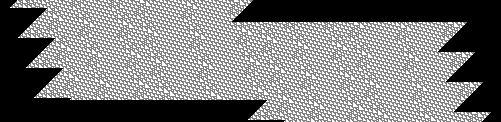

In [193]:
merged = glue_blocks(standard_blocks["H"], standard_blocks["H"])
merged = np.array(merged, dtype=np.uint8)
Image.fromarray(merged, mode="L") # mode L is for 8-bit monochromatic pixels